In [1]:


import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,LSTM
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
EMODB_PATH = '/content/drive/MyDrive/Prism/Prism/emodb/wav'

path = []
file_list = []

for root, dirs, files in os.walk(EMODB_PATH):
    for name in files:
        file_list.append(name)
        path.append(os.path.join(EMODB_PATH, name))

res = {file_list[i]: path[i] for i in range(len(file_list))}

speaker_list = {
    '03': {'gender': 'male', 'age': 31},
    '08': {'gender': 'female', 'age': 34},
    '09': {'gender': 'female', 'age': 21},
    '10': {'gender': 'male', 'age': 32},
    '11': {'gender': 'male', 'age': 26},
    '12': {'gender': 'male', 'age': 30},
    '13': {'gender': 'female', 'age': 32},
    '14': {'gender': 'female', 'age': 35},
    '15': {'gender': 'male', 'age': 25},
    '16': {'gender': 'female', 'age': 31}
}

emotions = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'anxiety/fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}

text_descriptions = {
    'a01': 'The tablecloth is lying on the frigde.',
    'a02': 'She will hand it in on Wednesday.',
    'a04': 'Tonight I could tell him.',
    'a05': 'The black sheet of paper is located up there besides the piece of timber.',
    'a07': 'In seven hours it will be.',
    'b01': 'What about the bags standing there under the table?',
    'b02': 'They just carried it upstairs and now they are going down again.',
    'b03': 'Currently at the weekends I always went home and saw Agnes.',
    'b09': 'I will just discard this and then go for a drink with Karl.',
    'b10': 'It will be in the place where we always store it.'
}


def extract_info(filename):
    speaker = filename[:2]
    text = filename[2:5]
    emotion = emotions[filename[5]]
    return filename, speaker, speaker_list[speaker]['gender'], speaker_list[speaker]['age'], emotion, text, text_descriptions[text], res[filename]

data = [extract_info(filename) for filename in file_list]

df = pd.DataFrame(data, columns=['File','Speaker', 'Gender', 'Age', 'Emotion', 'Text Code', 'Text Description','Path'])

print(df)

            File Speaker  Gender  Age       Emotion Text Code  \
0    03a02Fc.wav      03    male   31     happiness       a02   
1    03a01Fa.wav      03    male   31     happiness       a01   
2    03a02Wb.wav      03    male   31         anger       a02   
3    03a01Nc.wav      03    male   31       neutral       a01   
4    03a02Nc.wav      03    male   31       neutral       a02   
..           ...     ...     ...  ...           ...       ...   
530  15a02Na.wav      15    male   25       neutral       a02   
531  16b09Ab.wav      16  female   31  anxiety/fear       b09   
532  15b09La.wav      15    male   25       boredom       b09   
533  16a04Lc.wav      16  female   31       boredom       a04   
534  16b02Fd.wav      16  female   31     happiness       b02   

                                      Text Description  \
0                    She will hand it in on Wednesday.   
1               The tablecloth is lying on the frigde.   
2                    She will hand it in on W

In [4]:
CREMA_PATH = '/content/drive/MyDrive/Prism/Prism/crema-d/AudioWAV/'
import os
import numpy as np
import pandas as pd

data=pd.read_csv('/content/drive/MyDrive/Prism/Prism/crema-d/VideoDemographics.csv')

data.drop('Race',inplace=True,axis=1)

data.drop('Ethnicity',inplace=True,axis=1)

data.head()



,ActorID,Age,Sex
0,1001,51,Male
1,1002,21,Female
2,1003,21,Female
3,1004,42,Female
4,1005,29,Male


In [5]:
df2=pd.DataFrame()

In [6]:
abbreviations = {
    'IEO': "It's eleven o'clock.",
    'TIE': "That is exactly what happened.",
    'IOM': "I'm on my way to the meeting.",
    'IWW': "I wonder what this is about.",
    'TAI': "The airplane is almost full.",
    'MTI': "Maybe tomorrow it will be cold.",
    'IWL': "I would like a new alarm clock.",
    'ITH': "I think I have a doctor's appointment.",
    'DFA': "Don't forget a jacket.",
    'ITS': "I think I've seen this before.",
    'TSI': "The surface is slick.",
    'WSI': "We'll stop in a couple of minutes."
}

Emotion={
    'ANG':"anger",
    'DIS':"disgust",
    'FEA':"anxiety/fear",
    'HAP':"happiness",
    'NEU':"neutral",
    'SAD':"sad",
}

def get_age_sex(target_id):
    filtered_df = data[data['ActorID'] == target_id]
    if not filtered_df.empty:
        age = filtered_df['Age'].iloc[0]
        sex = filtered_df['Sex'].iloc[0].lower()
        return age,sex

folder_path= CREMA_PATH

import os

# Iterate over the files in the folder
for filename in os.listdir(folder_path):
    file=filename
    if filename.endswith('.wav'):
        # Remove the file extension (.wav)
        filename = filename[:-4]

        parts = filename.split('_')
        path=os.path.join(CREMA_PATH,file)
        if len(parts) == 4:
            actor_id = parts[0]
            age,sex=get_age_sex(int(actor_id))
            text_desc = parts[1]
            emo = parts[2]
            emo_level= parts[3]


            new_data = pd.DataFrame({'File': file,'Speaker':[int(actor_id)],'Gender':sex,'Age':[age],'Emotion':Emotion[emo],'Text Code':text_desc,'Text Description':abbreviations[text_desc],'Path':path})
            df2 = pd.concat([df2, new_data], ignore_index=True)
        else:
            print(f"Invalid filename format: {filename}")

df2.head()

,File,Speaker,Gender,Age,Emotion,Text Code,Text Description,Path
0,1072_MTI_FEA_XX.wav,1072,female,33,anxiety/fear,MTI,Maybe tomorrow it will be cold.,/content/drive/MyDrive/Prism/Prism/crema-d/Aud...
1,1072_TAI_FEA_XX.wav,1072,female,33,anxiety/fear,TAI,The airplane is almost full.,/content/drive/MyDrive/Prism/Prism/crema-d/Aud...
2,1072_TAI_SAD_XX.wav,1072,female,33,sad,TAI,The airplane is almost full.,/content/drive/MyDrive/Prism/Prism/crema-d/Aud...
3,1072_TAI_NEU_XX.wav,1072,female,33,neutral,TAI,The airplane is almost full.,/content/drive/MyDrive/Prism/Prism/crema-d/Aud...
4,1072_TAI_DIS_XX.wav,1072,female,33,disgust,TAI,The airplane is almost full.,/content/drive/MyDrive/Prism/Prism/crema-d/Aud...


In [7]:
# Selecting the desired columns from df1
df1_selected = df[['File', 'Speaker', 'Gender', 'Age', 'Emotion', 'Path']]

# Selecting the desired columns from df2
df2_selected = df2[['File', 'Speaker', 'Gender', 'Age', 'Emotion', 'Path']]

# Combining the selected columns from both dataframes into a new dataframe
combined_df = pd.concat([df1_selected, df2_selected], axis=0)

# Resetting the index of the combined dataframe
combined_df.reset_index(drop=True, inplace=True)

In [8]:
hop_length = 512

In [9]:
combined_df['Emotion'] = combined_df['Emotion'].replace('sadness', 'sad') # combining 'sadness' and 'sad' together

In [10]:
combined_df.Emotion.value_counts()

anger           899
anxiety/fear    886
happiness       868
sad             834
disgust         814
neutral         756
boredom          81
Name: Emotion, dtype: int64

In [11]:
combined_df = combined_df[combined_df['Emotion'] != 'boredom'] # dropping all rows with boredom

In [12]:
combined_df.Emotion.value_counts()

anger           899
anxiety/fear    886
happiness       868
sad             834
disgust         814
neutral         756
Name: Emotion, dtype: int64

In [13]:
combined_df.columns

Index(['File', 'Speaker', 'Gender', 'Age', 'Emotion', 'Path'], dtype='object')

In [14]:
combined_df['Age'] = pd.cut(combined_df['Age'], bins=[20, 29, 39, 49, 59, 69, 79],
                           labels=['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies'],
                           right=False) # Converting age to categorical variables

In [15]:
df = combined_df

In [16]:
def noise(data,noise_rate=0.015):
    noise_amp = noise_rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

path = df['Path'][1]
data, sample_rate = librosa.load(path)

In [17]:
# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)
#RMS Energy
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)
#MFCC
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [18]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [19]:
def get_features(path):
    #duration, offset
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    res1 = extract_features(data,sample_rate)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2))

    data_pitch = pitch(data, sample_rate)
    res3 = extract_features(data_pitch,sample_rate)
    result = np.vstack((result, res3))

    data_noise_pitch = noise(data_pitch)
    res4 = extract_features(data_noise_pitch,sample_rate)
    result = np.vstack((result, res4))

    return result

In [20]:
X,Y = [], []
for path, age in zip(df.Path, df.Age):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(age)

In [21]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('/content/drive/MyDrive/Prism/features_age.csv', index=False)
Features.head(20)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.032715,0.059570,0.076660,0.065918,0.053223,0.031738,0.019531,0.020508,0.020508,0.023926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thirties
1,0.035645,0.064453,0.087402,0.078125,0.065918,0.047363,0.035156,0.041016,0.042969,0.041504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thirties
2,0.036621,0.057617,0.082031,0.076660,0.060547,0.044922,0.025879,0.020996,0.024414,0.028320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thirties
3,0.037598,0.057617,0.083008,0.077637,0.060547,0.045898,0.026855,0.021973,0.025391,0.028320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thirties
4,0.014648,0.026367,0.039062,0.043457,0.043945,0.039551,0.067383,0.098633,0.099121,0.107910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thirties
5,0.030273,0.048828,0.068359,0.071777,0.063477,0.055176,0.099609,0.189941,0.304199,0.380859,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thirties
6,0.017578,0.027344,0.044922,0.054688,0.051270,0.066406,0.114746,0.163086,0.205078,0.207520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thirties
7,0.016602,0.027344,0.045898,0.056641,0.055176,0.072266,0.120605,0.170898,0.227539,0.231934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thirties
8,0.224609,0.271484,0.302246,0.229004,0.146973,0.125000,0.126953,0.103027,0.086914,0.069336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thirties
9,0.223633,0.269531,0.301270,0.230957,0.149902,0.131836,0.131836,0.106934,0.090820,0.071289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,thirties


In [22]:
X,Y = [], []
for path, emo in zip(df.Path, df.Emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emo)

In [24]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('/content/drive/MyDrive/Prism/features_emotion_final.csv', index=False)
Features.head(20)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.032715,0.059570,0.076660,0.065918,0.053223,0.031738,0.019531,0.020508,0.020508,0.023926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happiness
1,0.032715,0.059570,0.076660,0.065918,0.053223,0.031738,0.019531,0.020508,0.020508,0.023926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happiness
2,0.036621,0.057617,0.082031,0.076660,0.060547,0.044922,0.025879,0.020996,0.024414,0.028320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happiness
3,0.036621,0.057617,0.083008,0.079590,0.064453,0.050781,0.032715,0.028809,0.038086,0.040039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happiness
4,0.014648,0.026367,0.039062,0.043457,0.043945,0.039551,0.067383,0.098633,0.099121,0.107910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happiness
5,0.025391,0.040039,0.051758,0.055176,0.052734,0.048340,0.083008,0.148438,0.257812,0.323730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happiness
6,0.017578,0.027344,0.044922,0.054688,0.051270,0.066406,0.114746,0.163086,0.205078,0.207520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happiness
7,0.019531,0.033203,0.053711,0.071289,0.065918,0.081055,0.130371,0.189453,0.261719,0.267090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happiness
8,0.224609,0.271484,0.302246,0.229004,0.146973,0.125000,0.126953,0.103027,0.086914,0.069336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,anger
9,0.227539,0.276367,0.312012,0.238770,0.155762,0.132812,0.129883,0.104980,0.090820,0.077148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,anger


In [3]:
Features = pd.read_csv('/content/drive/MyDrive/Prism/features_emotion_final.csv')

In [4]:
Features = Features.fillna(0)
print(Features.isna().any())
Features.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(20228, 2377)

In [5]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [6]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
encoder.categories_

[array(['anger', 'anxiety/fear', 'disgust', 'happiness', 'neutral', 'sad'],
       dtype=object)]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.15, random_state=30, shuffle=True,stratify=Y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17193, 2376), (17193, 6), (3035, 2376), (3035, 6))

In [10]:
scaler = StandardScaler()

In [11]:

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, random_state=30, test_size=0.25, shuffle=True,stratify=y_test)
x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape

((17193, 2376),
 (2276, 2376),
 (759, 2376),
 (17193, 2376),
 (2276, 2376),
 (759, 2376))

In [12]:
x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17193, 2376), (17193, 6), (2276, 2376), (2276, 6))

In [13]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17193, 2376, 1), (17193, 6), (2276, 2376, 1), (2276, 6))

In [14]:
optimizer = keras.optimizers.Adam(lr=0.0005)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
model=Sequential()

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(6, activation='softmax'))
model.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 2376, 256)         1536      
                                                                 
 batch_normalization_5 (Batc  (None, 2376, 256)        1024      
 hNormalization)                                                 
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1188, 256)        0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 1188, 256)         327936    
                                                                 
 batch_normalization_6 (Batc  (None, 1188, 256)        1024      
 hNormalization)                                                 
                                                      

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, start_from_epoch=20)
callbacks=[learning_rate_reduction,early_stop]



In [18]:
history=model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/100
538/538 [==============================] - 50s 66ms/step - loss: 1.6129 - accuracy: 0.3582 - val_loss: 1.6185 - val_accuracy: 0.3755 - lr: 0.0010
Epoch 2/100
538/538 [==============================] - 35s 66ms/step - loss: 1.4024 - accuracy: 0.4341 - val_loss: 1.7261 - val_accuracy: 0.4242 - lr: 0.0010
Epoch 3/100
538/538 [==============================] - 36s 66ms/step - loss: 1.3140 - accuracy: 0.4771 - val_loss: 1.3886 - val_accuracy: 0.4216 - lr: 0.0010
Epoch 4/100
538/538 [==============================] - 36s 67ms/step - loss: 1.2632 - accuracy: 0.4993 - val_loss: 1.2726 - val_accuracy: 0.4914 - lr: 0.0010
Epoch 5/100
538/538 [==============================] - 35s 66ms/step - loss: 1.1879 - accuracy: 0.5345 - val_loss: 1.2912 - val_accuracy: 0.4888 - lr: 0.0010
Epoch 6/100
538/538 [==============================] - 35s 66ms/step - loss: 1.1044 - accuracy: 0.5669 - val_loss: 1.0844 - val_accuracy: 0.5679 - lr: 0.0010
Epoch 7/100
538/538 [==============================]

In [19]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

72/72 [==============================] - 2s 23ms/step - loss: 0.1429 - accuracy: 0.9547
Accuracy of our model on test data :  95.47451734542847 %


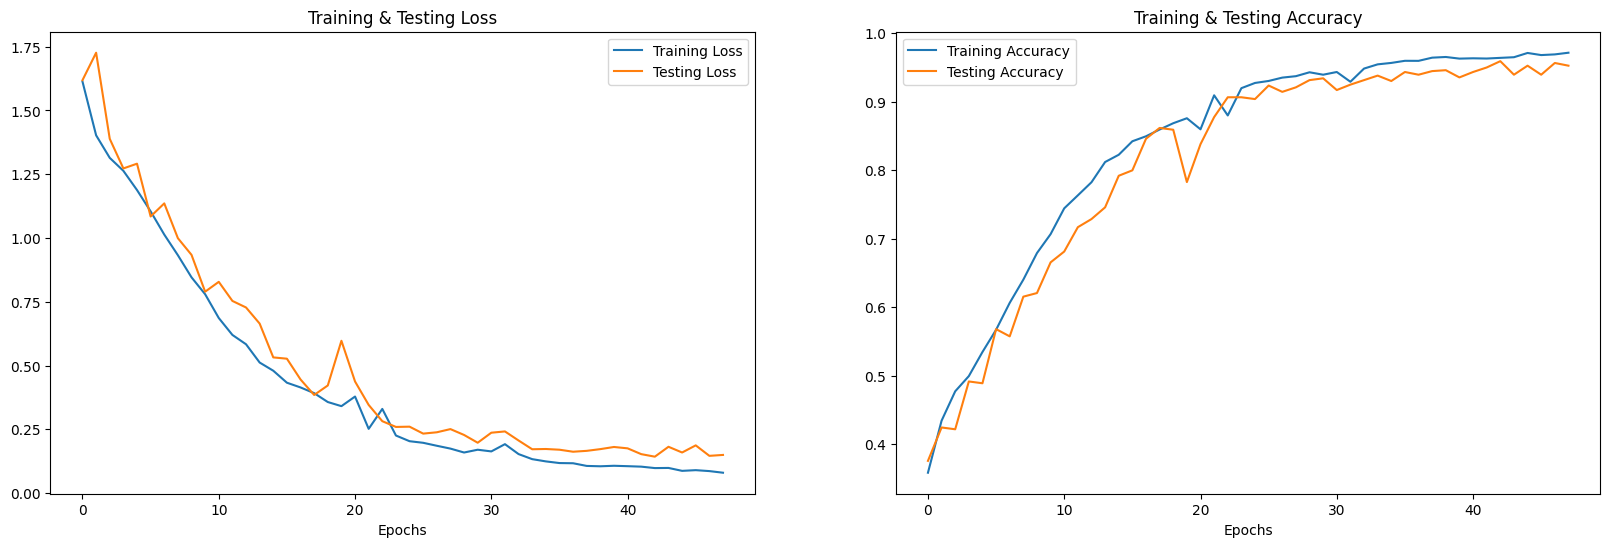

In [22]:
epochs = [i for i in range(early_stop.stopped_epoch+1) ]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [23]:
pred_test = model.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

72/72 [==============================] - 2s 23ms/step


In [24]:
pred_test=model.predict(x_test)

72/72 [==============================] - 2s 27ms/step


In [25]:
df_temp = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_temp['Predicted Labels'] = y_pred.flatten()
df_temp['Actual Labels'] = y_test.flatten()

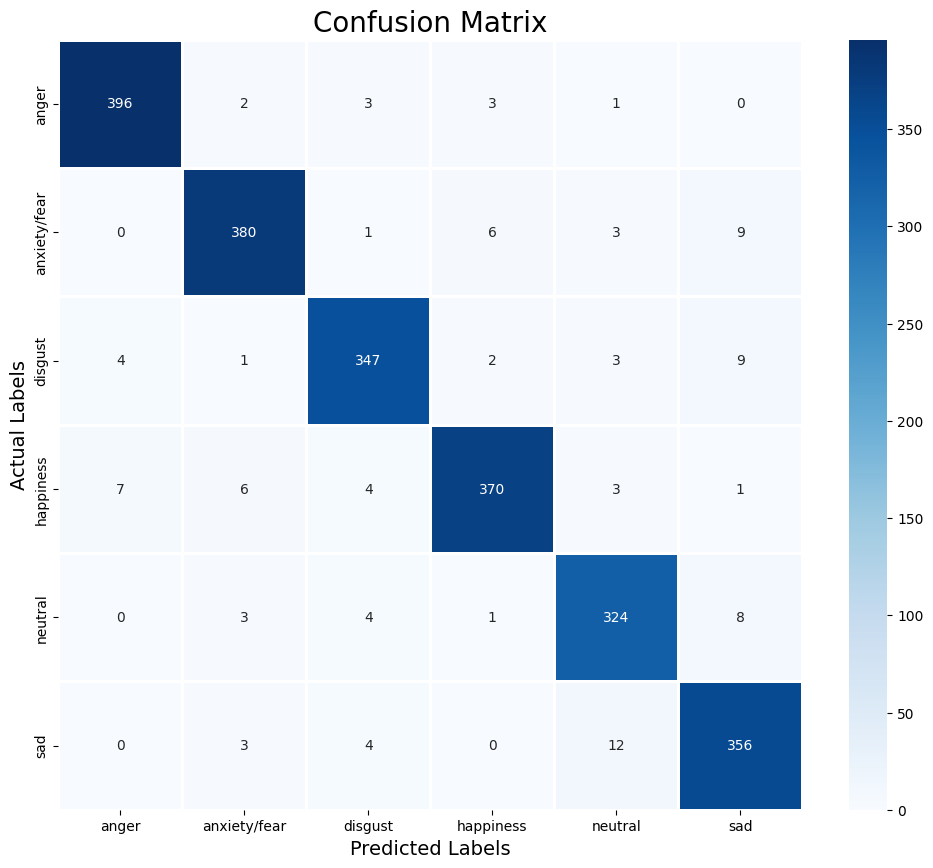

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [27]:
print(classification_report(y_test, y_pred, target_names=['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies']))

              precision    recall  f1-score   support

    twenties       0.97      0.98      0.98       405
    thirties       0.96      0.95      0.96       399
     forties       0.96      0.95      0.95       366
     fifties       0.97      0.95      0.96       391
     sixties       0.94      0.95      0.94       340
   seventies       0.93      0.95      0.94       375

    accuracy                           0.95      2276
   macro avg       0.95      0.95      0.95      2276
weighted avg       0.95      0.95      0.95      2276



## From features and predicted emotion, predict gender

In [28]:
Features = pd.read_csv('/content/drive/MyDrive/Prism/features_gender_final.csv')

In [29]:
Features = Features.fillna(0)
print(Features.isna().any())
Features.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(31584, 2377)

In [30]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [31]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X)
X1 = np.expand_dims(X1, axis=2)

In [32]:
Z=model.predict(X1)

987/987 [==============================] - 20s 21ms/step


In [33]:
Z = encoder.inverse_transform(Z)

In [34]:
Z = Z.flatten()

In [37]:
Features = pd.DataFrame(X)
Features['predicted emotion'] = Z
Features['labels'] = Y

In [38]:
Features

,0,1,2,3,4,5,6,7,8,9,...,2368,2369,2370,2371,2372,2373,2374,2375,predicted emotion,labels
0,0.032715,0.059570,0.076660,0.065918,0.053223,0.031738,0.019531,0.020508,0.020508,0.023926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happiness,male
1,0.032715,0.061523,0.080566,0.069824,0.058105,0.035645,0.022461,0.023438,0.022461,0.024902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happiness,male
2,0.036621,0.057617,0.082031,0.076660,0.060547,0.044922,0.025879,0.020996,0.024414,0.028320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happiness,male
3,0.036621,0.057617,0.082031,0.076660,0.060547,0.044922,0.025879,0.020996,0.024414,0.028320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happiness,male
4,0.014648,0.026367,0.039062,0.043457,0.043945,0.039551,0.067383,0.098633,0.099121,0.107910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,happiness,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31579,0.027832,0.040039,0.055176,0.053711,0.048828,0.044922,0.039551,0.037598,0.043457,0.059082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,anxiety/fear,female
31580,0.015625,0.022461,0.028809,0.031250,0.028320,0.029785,0.033691,0.032715,0.035645,0.032227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad,female
31581,0.021484,0.034180,0.048340,0.055664,0.050781,0.049316,0.053223,0.055664,0.060059,0.053711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad,female
31582,0.011719,0.018066,0.022461,0.024414,0.023438,0.023438,0.028809,0.031250,0.030762,0.031738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad,female


In [39]:
Features['predicted emotion'] = Features['predicted emotion'].astype('category').cat.codes

In [40]:
Features

,0,1,2,3,4,5,6,7,8,9,...,2368,2369,2370,2371,2372,2373,2374,2375,predicted emotion,labels
0,0.032715,0.059570,0.076660,0.065918,0.053223,0.031738,0.019531,0.020508,0.020508,0.023926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,male
1,0.032715,0.061523,0.080566,0.069824,0.058105,0.035645,0.022461,0.023438,0.022461,0.024902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,male
2,0.036621,0.057617,0.082031,0.076660,0.060547,0.044922,0.025879,0.020996,0.024414,0.028320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,male
3,0.036621,0.057617,0.082031,0.076660,0.060547,0.044922,0.025879,0.020996,0.024414,0.028320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,male
4,0.014648,0.026367,0.039062,0.043457,0.043945,0.039551,0.067383,0.098633,0.099121,0.107910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31579,0.027832,0.040039,0.055176,0.053711,0.048828,0.044922,0.039551,0.037598,0.043457,0.059082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,female
31580,0.015625,0.022461,0.028809,0.031250,0.028320,0.029785,0.033691,0.032715,0.035645,0.032227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,female
31581,0.021484,0.034180,0.048340,0.055664,0.050781,0.049316,0.053223,0.055664,0.060059,0.053711,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,female
31582,0.011719,0.018066,0.022461,0.024414,0.023438,0.023438,0.028809,0.031250,0.030762,0.031738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,female


In [41]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [42]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
encoder.categories_

[array(['female', 'male'], dtype=object)]

In [43]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.15, random_state=30, shuffle=True,stratify=Y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26846, 2377), (26846, 2), (4738, 2377), (4738, 2))

In [44]:
scaler = StandardScaler()

In [45]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, random_state=30, test_size=0.25, shuffle=True,stratify=y_test)
x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape

((26846, 2377),
 (3553, 2377),
 (1185, 2377),
 (26846, 2377),
 (3553, 2377),
 (1185, 2377))

In [46]:
x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26846, 2377), (26846, 2), (3553, 2377), (3553, 2))

In [47]:
optimizer = keras.optimizers.Adam(lr=0.0005)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [48]:
model2=Sequential()

model2.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model2.add(Dropout(0.2))

model2.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(2, activation='softmax'))
model2.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 2377, 256)         1536      
                                                                 
 batch_normalization_10 (Bat  (None, 2377, 256)        1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1189, 256)        0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 1189, 256)         327936    
                                                                 
 batch_normalization_11 (Bat  (None, 1189, 256)        1024      
 chNormalization)                                                
                                                      

In [49]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, start_from_epoch=20)
callbacks=[learning_rate_reduction,early_stop]



In [50]:
history2=model2.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/100
839/839 [==============================] - 63s 67ms/step - loss: 0.5055 - accuracy: 0.7543 - val_loss: 0.6461 - val_accuracy: 0.6776 - lr: 0.0010
Epoch 2/100
839/839 [==============================] - 54s 65ms/step - loss: 0.3119 - accuracy: 0.8690 - val_loss: 0.3434 - val_accuracy: 0.8549 - lr: 0.0010
Epoch 3/100
839/839 [==============================] - 54s 65ms/step - loss: 0.2705 - accuracy: 0.8880 - val_loss: 0.4659 - val_accuracy: 0.8068 - lr: 0.0010
Epoch 4/100
839/839 [==============================] - 54s 65ms/step - loss: 0.2497 - accuracy: 0.8946 - val_loss: 0.2266 - val_accuracy: 0.9080 - lr: 0.0010
Epoch 5/100
839/839 [==============================] - 54s 64ms/step - loss: 0.2276 - accuracy: 0.9062 - val_loss: 0.2121 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 6/100
839/839 [==============================] - 54s 64ms/step - loss: 0.2142 - accuracy: 0.9154 - val_loss: 0.4138 - val_accuracy: 0.8152 - lr: 0.0010
Epoch 7/100
839/839 [==============================]

In [52]:
print("Accuracy of our model on test data : " , model2.evaluate(x_test,y_test)[1]*100 , "%")

112/112 [==============================] - 2s 20ms/step - loss: 0.0254 - accuracy: 0.9907
Accuracy of our model on test data :  99.071204662323 %


In [53]:
pred_test = model2.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

112/112 [==============================] - 2s 18ms/step


In [54]:
pred_test=model2.predict(x_test)

112/112 [==============================] - 2s 21ms/step


In [55]:
df_temp2 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_temp2['Predicted Labels'] = y_pred.flatten()
df_temp2['Actual Labels'] = y_test.flatten()

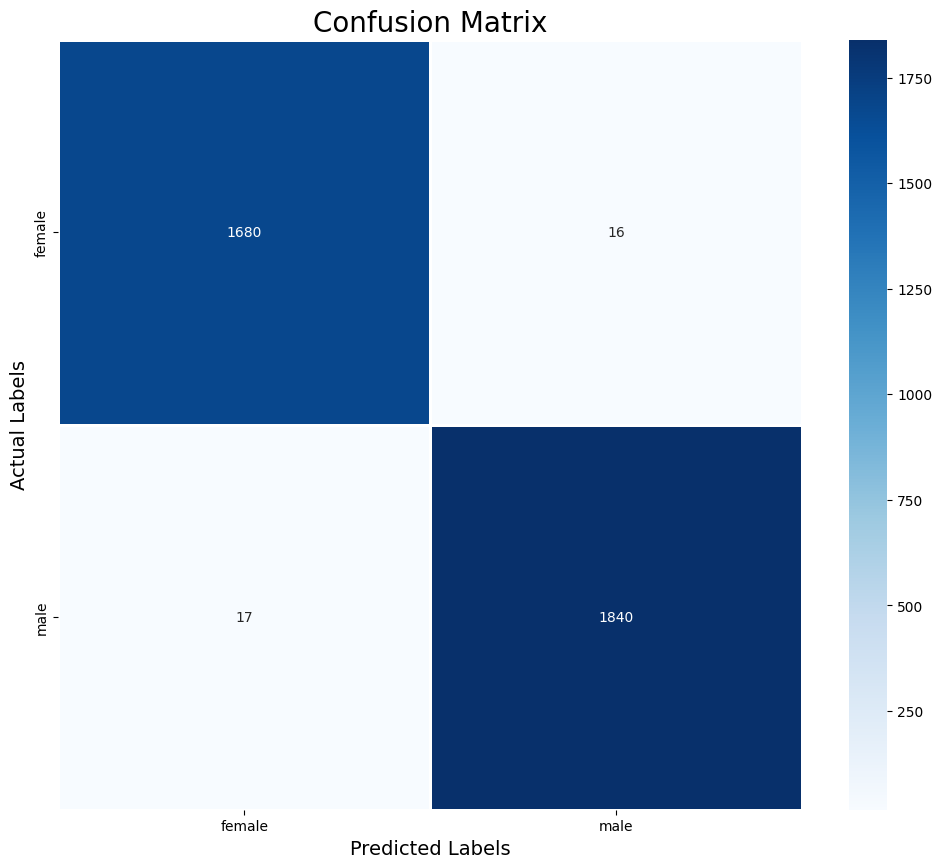

In [56]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

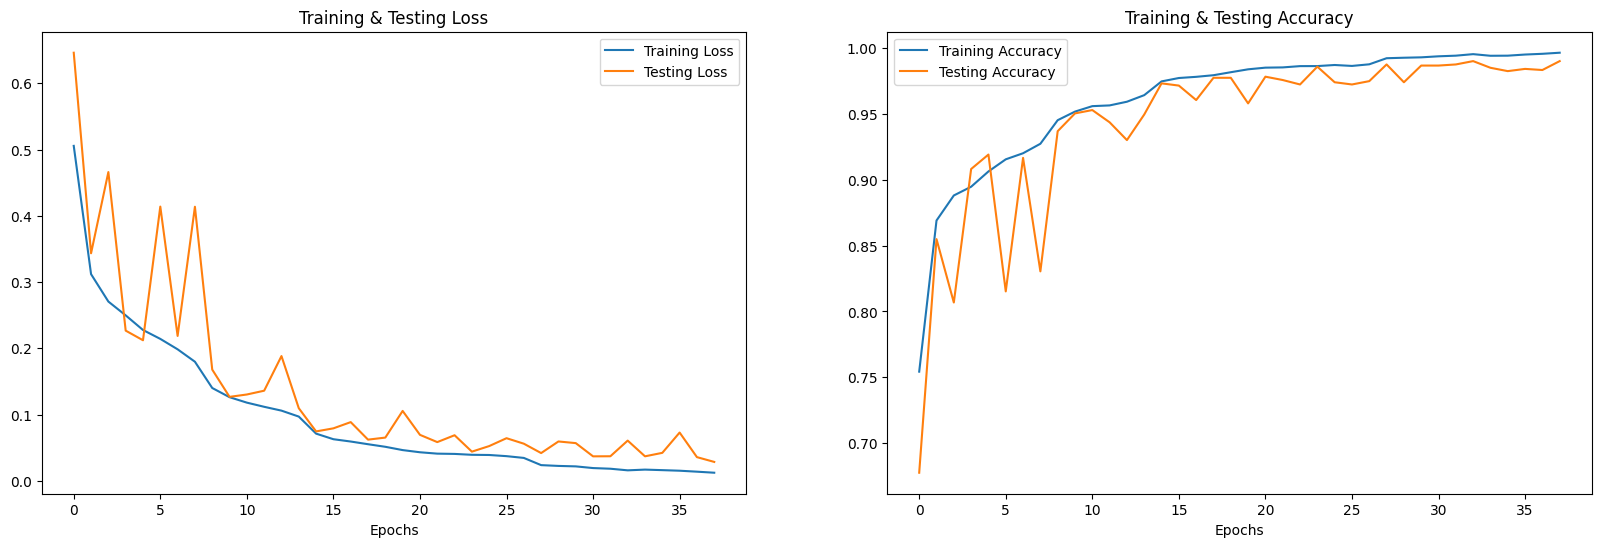

In [57]:
epochs = [i for i in range(early_stop.stopped_epoch+1) ]
fig , ax = plt.subplots(1,2)
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']
test_acc = history2.history['val_accuracy']
test_loss = history2.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [59]:
print(classification_report(y_test, y_pred, target_names=['male','female']))

              precision    recall  f1-score   support

        male       0.99      0.99      0.99      1696
      female       0.99      0.99      0.99      1857

    accuracy                           0.99      3553
   macro avg       0.99      0.99      0.99      3553
weighted avg       0.99      0.99      0.99      3553



## From features and predicted gender, predict Age

In [60]:
Features = pd.read_csv('/content/drive/MyDrive/Prism/features_age_final.csv')

In [61]:
Features = Features.fillna(0)
print(Features.isna().any())
Features.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(20228, 2377)

In [67]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [68]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X)
X1 = np.expand_dims(X1, axis=2)

In [69]:
Z=model2.predict(X1)

633/633 [==============================] - 13s 20ms/step


In [70]:
Z = encoder.inverse_transform(Z)

In [71]:
Z = Z.flatten()

In [75]:
Features = pd.DataFrame(X)
Features['predicted gender'] = Z
Features['labels'] = Y

In [76]:
Features['predicted gender'] = Features['predicted gender'].astype('category').cat.codes

In [77]:
Features

,0,1,2,3,4,5,6,7,8,9,...,2368,2369,2370,2371,2372,2373,2374,2375,predicted gender,labels
0,0.032715,0.059570,0.076660,0.065918,0.053223,0.031738,0.019531,0.020508,0.020508,0.023926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,thirties
1,0.035645,0.064453,0.087402,0.078125,0.065918,0.047363,0.035156,0.041016,0.042969,0.041504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,thirties
2,0.036621,0.057617,0.082031,0.076660,0.060547,0.044922,0.025879,0.020996,0.024414,0.028320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,thirties
3,0.037598,0.057617,0.083008,0.077637,0.060547,0.045898,0.026855,0.021973,0.025391,0.028320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,thirties
4,0.014648,0.026367,0.039062,0.043457,0.043945,0.039551,0.067383,0.098633,0.099121,0.107910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,thirties
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20223,0.020020,0.040527,0.060059,0.062500,0.058105,0.046875,0.037598,0.042480,0.044922,0.047363,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,twenties
20224,0.010742,0.017578,0.023926,0.027344,0.033691,0.050293,0.069824,0.083984,0.093750,0.086914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,twenties
20225,0.040039,0.070801,0.101074,0.104004,0.115723,0.110840,0.106934,0.105469,0.096680,0.087891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,twenties
20226,0.011719,0.019043,0.024414,0.031250,0.048340,0.070312,0.087891,0.099609,0.093262,0.080078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,twenties


In [78]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [79]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
encoder.categories_

[array(['fifties', 'forties', 'seventies', 'sixties', 'thirties',
        'twenties'], dtype=object)]

In [80]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.15, random_state=30, shuffle=True,stratify=Y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17193, 2377), (17193, 6), (3035, 2377), (3035, 6))

In [81]:
scaler = StandardScaler()

In [82]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, random_state=30, test_size=0.25, shuffle=True,stratify=y_test)
x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape

((17193, 2377),
 (2276, 2377),
 (759, 2377),
 (17193, 2377),
 (2276, 2377),
 (759, 2377))

In [83]:
x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17193, 2377), (17193, 6), (2276, 2377), (2276, 6))

In [84]:
optimizer = keras.optimizers.Adam(lr=0.0005) ####

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [85]:
model3=Sequential()

model3.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model3.add(BatchNormalization())
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model3.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model3.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model3.add(Dropout(0.2))

model3.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model3.add(Flatten())
model3.add(Dense(32, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(6, activation='softmax'))
model3.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 2377, 256)         1536      
                                                                 
 batch_normalization_15 (Bat  (None, 2377, 256)        1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 1189, 256)        0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 1189, 256)         327936    
                                                                 
 batch_normalization_16 (Bat  (None, 1189, 256)        1024      
 chNormalization)                                                
                                                      

In [86]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, start_from_epoch=20)
callbacks=[learning_rate_reduction,early_stop]



In [87]:
history3=model3.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/100
538/538 [==============================] - 42s 68ms/step - loss: 1.6999 - accuracy: 0.3020 - val_loss: 1.4948 - val_accuracy: 0.3465 - lr: 0.0010
Epoch 2/100
538/538 [==============================] - 36s 67ms/step - loss: 1.4669 - accuracy: 0.3549 - val_loss: 1.4639 - val_accuracy: 0.3610 - lr: 0.0010
Epoch 3/100
538/538 [==============================] - 37s 68ms/step - loss: 1.3795 - accuracy: 0.3898 - val_loss: 1.3900 - val_accuracy: 0.3887 - lr: 0.0010
Epoch 4/100
538/538 [==============================] - 35s 66ms/step - loss: 1.3365 - accuracy: 0.4099 - val_loss: 1.3891 - val_accuracy: 0.3992 - lr: 0.0010
Epoch 5/100
538/538 [==============================] - 35s 65ms/step - loss: 1.2753 - accuracy: 0.4474 - val_loss: 1.3771 - val_accuracy: 0.3913 - lr: 0.0010
Epoch 6/100
538/538 [==============================] - 34s 64ms/step - loss: 1.2200 - accuracy: 0.4797 - val_loss: 1.3010 - val_accuracy: 0.4269 - lr: 0.0010
Epoch 7/100
538/538 [==============================]

In [88]:
print("Accuracy of our model on test data : " , model3.evaluate(x_test,y_test)[1]*100 , "%")

72/72 [==============================] - 2s 21ms/step - loss: 0.1936 - accuracy: 0.9433
Accuracy of our model on test data :  94.33216452598572 %


In [89]:
pred_test = model3.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

72/72 [==============================] - 1s 17ms/step


In [90]:
pred_test=model3.predict(x_test)

72/72 [==============================] - 1s 17ms/step


In [91]:
df_temp3 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_temp3['Predicted Labels'] = y_pred.flatten()
df_temp3['Actual Labels'] = y_test.flatten()

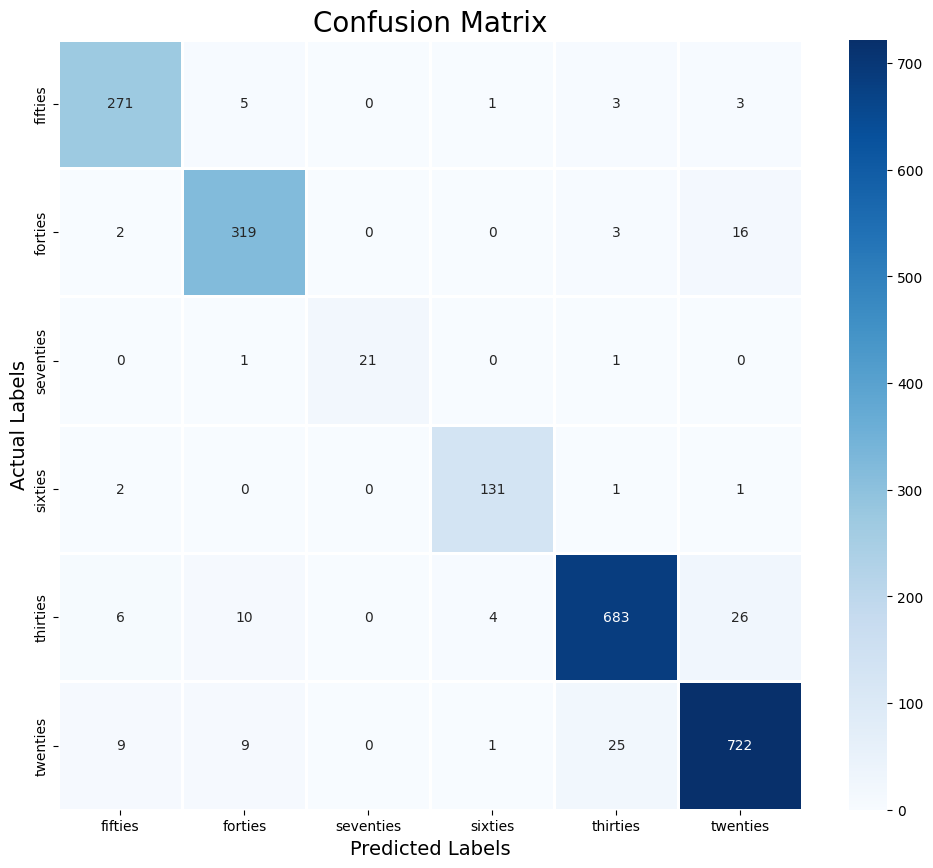

In [92]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

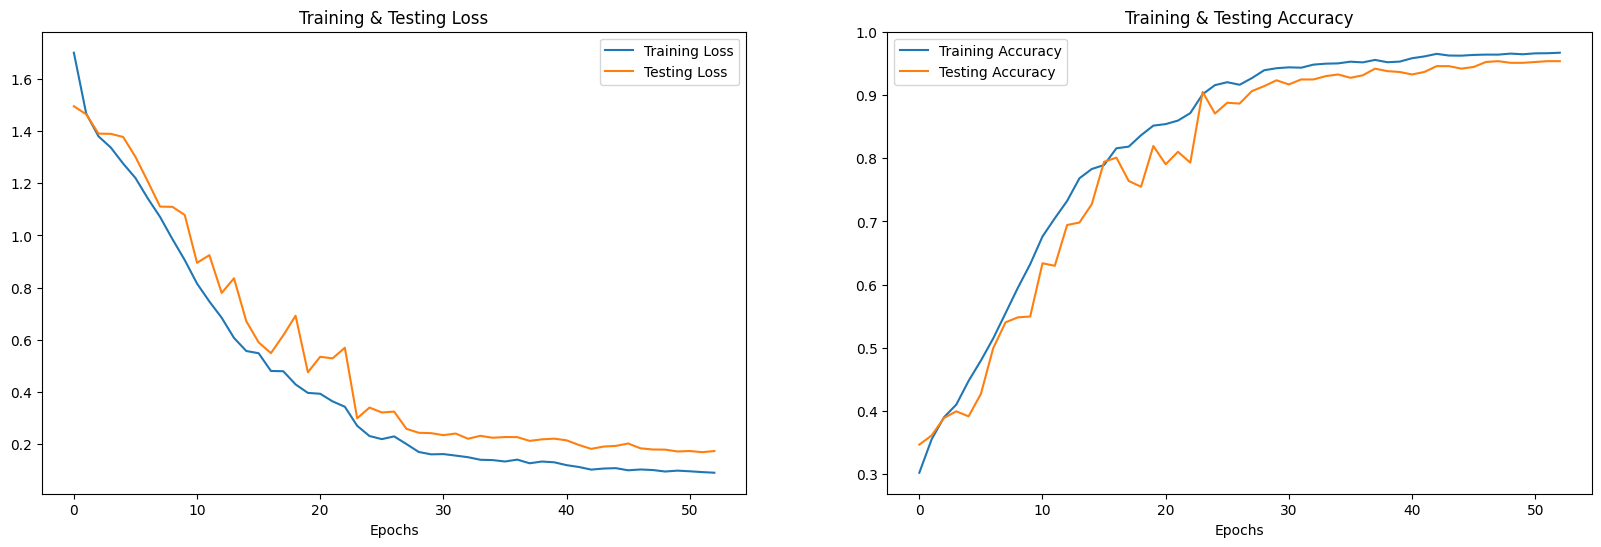

In [93]:
epochs = [i for i in range(early_stop.stopped_epoch+1) ]
fig , ax = plt.subplots(1,2)
train_acc = history3.history['accuracy']
train_loss = history3.history['loss']
test_acc = history3.history['val_accuracy']
test_loss = history3.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [94]:
print(classification_report(y_test, y_pred, target_names=['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies']))

              precision    recall  f1-score   support

    twenties       0.93      0.96      0.95       283
    thirties       0.93      0.94      0.93       340
     forties       1.00      0.91      0.95        23
     fifties       0.96      0.97      0.96       135
     sixties       0.95      0.94      0.95       729
   seventies       0.94      0.94      0.94       766

    accuracy                           0.94      2276
   macro avg       0.95      0.94      0.95      2276
weighted avg       0.94      0.94      0.94      2276

